---
title: Programming Assignment 3
author: Péter Ferenc Gyarmati (11913446)
date: '2023.11.22'
format:
    html:
        code-fold: true
---

In [1]:
import altair as alt
from IPython.display import display, Image


def display_chart(chart: alt.Chart, scale_factor=2):
    chart.save("chart.png", scale_factor=scale_factor)
    display(Image("chart.png"))

# Task 1: Kernelized SVM

In this task you will work with the "digits" data set [4]. Load the training and testing data (`sklearn.datasets.load_digits`). Split the dataset to use 70% of the data for training and 30 % of the data for testing. Use a SVM (`sklearn.svm.SVC`) for classification and accuracy as metric (`sklearn.metrics.accuracy_score`).

In [2]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Load the dataset and split it
digits = load_digits()
X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target, test_size=0.3, random_state=9000
)

# Create and train SVM classifier
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train)

# Predict and check the accuracy
y_pred = svm_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy Score: {accuracy}")

Accuracy Score: 0.9888888888888889


## Subtask 1: SVMs With Different Kernels

Evaluate a support vector machine (using default parameters except for the kernel) on the dataset, using different kernels (linear, poly, rbf, sigmoid). Select good hyperparameters for the kernels using model selection techniques.

- Report the classification accuracies on the training and test set and how much the model selection improved performance
- Also report your hyperparameters and how you selected them

---

I set off by creating some utility functions to evaluate the accuracy of an SVM using a specific kernel with a set of hyperparameters, to produce evaluation results of multiple kernels with multiple configurations as well as to plot the results. I also used `grid_search_svm_kernel` to use `GridSearchCV` for model selection.

In [3]:
import numpy as np
from typing import Any, TypedDict, Literal
import altair as alt
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from itertools import product

KernelType = Literal["linear", "poly", "rbf", "sigmoid"]


class KernelComparisonResult(TypedDict):
    kernel: KernelType
    params: dict[str, Any]
    test_accuracy: float


def evaluate_svm_kernel(
    kernel: KernelType | Any,
    params: dict[str, Any],
    X_train: np.ndarray,
    X_test: np.ndarray,
    y_train: np.ndarray,
    y_test: np.ndarray,
) -> float:
    """Evaluate the accuracy of an SVM classifier with the given kernel and parameters."""
    svm = SVC(kernel=kernel, **params)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    return test_accuracy


def compare_svm_kernels(
    kernels: list[KernelType],
    kernel_params: dict[KernelType, list[dict[str, Any]]],
    X_train: np.ndarray,
    X_test: np.ndarray,
    y_train: np.ndarray,
    y_test: np.ndarray,
) -> list[KernelComparisonResult]:
    """Compare the accuracy of SVM classifiers with different kernels and parameters."""
    results = []

    for kernel in tqdm(kernels, desc="Evaluating different kernels"):
        for params in kernel_params.get(kernel, [{}]):
            test_accuracy = evaluate_svm_kernel(
                kernel, params, X_train, X_test, y_train, y_test
            )
            results.append(
                {
                    "kernel": kernel,
                    "params": params,
                    "test_accuracy": test_accuracy,
                }
            )

    return results


def create_kernel_comparison_chart(
    results: list[KernelComparisonResult],
    best_params: dict[KernelType, KernelComparisonResult],
) -> alt.Chart:
    """
    Create a chart comparing the accuracy of SVM classifiers 
    with different kernels and parameters.
    """
    df_results = pd.DataFrame(results)

    def params_to_string(params: dict) -> str:
        # {key1: value1, key2: value2} -> "key1=value1, key2=value2"
        return ", ".join([f"{key}={value}" for key, value in sorted(params.items())])

    # project `params` to a string so that we can use it as a nominal variable
    df_results["params"] = df_results["params"].apply(params_to_string)
    df_results_by_kernel = df_results.groupby("kernel")

    # One chart per kernel type
    charts = []
    for kernel, df in df_results_by_kernel:
        label_expr = f"datum.params == '{params_to_string(best_params[kernel]['params'])}' ? 'Selected as best' : 'Non-best'"
        chart = (
            alt.Chart(df)
            .transform_calculate(label=label_expr)
            .mark_bar()
            .encode(
                x=alt.X(
                    "params",
                    title="Parameters",
                    sort=alt.EncodingSortField(
                        field="test_accuracy", order="descending"
                    ),
                    axis=alt.Axis(labelFontSize=8),
                ),
                y=alt.Y("test_accuracy", title="Test Accuracy"),
                color=alt.Color(
                    "label:N",
                    legend=alt.Legend(title="Parameters"),
                ),
                tooltip=["params", "test_accuracy"],
            )
            .properties(title=f"Kernel: {kernel}", height=300)
        )
        charts.append(chart)

    # Combine all charts into one, display them side-by-side
    return (
        alt.hconcat(*charts)
        .properties(title="SVM Kernel Comparison")
        .resolve_scale(y="shared")
    )


def grid_search_svm_kernel(
    kernel: KernelType,
    param_grid: dict,
    X_train: np.ndarray,
    X_test: np.ndarray,
    y_train: np.ndarray,
    y_test: np.ndarray,
) -> KernelComparisonResult:
    """Grid search for the best parameters for an SVM classifier with the given kernel."""
    svm = SVC(kernel=kernel)
    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring="accuracy")
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_svm = SVC(kernel=kernel, **best_params)
    best_svm.fit(X_train, y_train)
    y_pred = best_svm.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)

    return {"kernel": kernel, "params": best_params, "test_accuracy": test_accuracy}


def select_best_parameters(
    param_grid: dict[KernelType, dict]
) -> dict[KernelType, KernelComparisonResult]:
    """Select the best parameters for SVM classifiers with different kernels."""
    return {
        kernel: grid_search_svm_kernel(
            kernel, param_grid_single, X_train, X_test, y_train, y_test
        )
        for kernel, param_grid_single in tqdm(param_grid.items(), desc="Grid search")
    }


def expand_single_grid(param_grid: dict[str, list]) -> list[dict]:
    """
    Expand a single grid of parameters into a list of parameter sets.

    E.g.: 
    {"a": [1, 2], "b": [3, 4]} -> 
    [{"a": 1, "b": 3}, {"a": 1, "b": 4}, {"a": 2, "b": 3}, {"a": 2, "b": 4}]
    """
    product_params = list(product(*param_grid.values()))
    return [dict(zip(param_grid.keys(), params)) for params in product_params]

Having all the utilities at hand, I defined `param_grid`, a dictionary of hyperparameter configurations for each kernel, and used it to evaluate the SVMs with the different kernels.

### Hyperparameter Selection

The `param_grid` in the provided snippet is designed for tuning hyperparameters of a Support Vector Machine (SVM) model. Here's a breakdown of what each parameter means and why the specified values are interesting to try:

#### Linear Kernel (`linear`)

- **C**: Regularization parameter. The strength of the regularization is inversely proportional to C. Smaller values specify stronger regularization. Trying values like `[0.1, 1, 10]` covers a range from strong to weak regularization. This helps to understand how much regularization the model needs (too much regularization can lead to underfitting, while too little can cause overfitting).

#### Polynomial Kernel (`poly`)

- **degree**: Degree of the polynomial kernel function (`'poly'`). It specifies the degree of the polynomial used in the kernel. Trying `[1, 3, 5]` explores the effect of using a linear (`1`), cubic (`3`), and a higher degree polynomial (`5`). This helps in understanding how complex the model should be to capture the data's structure.
- **C**: As above, it’s about regularization.
- **coef0**: Independent term in kernel function. It is a trade-off term in polynomial kernel and can adjust the influence of higher-degree terms in the model. `[0, 1]` allows us to see the effect of not having the term versus having a moderate influence.

#### Radial Basis Function Kernel (`rbf`)

- **C**: As above, it’s about regularization.
- **gamma**: For the `rbf` kernel, it defines how far the influence of a single training example reaches, with low values meaning 'far' and high values meaning close. The values `[0.01, 0.1, "scale"]` lets us explore from lower to higher influence, while `"scale"` automatically uses `1 / (n_features * X.var())` as the value of gamma, which is a good default heuristic.

#### Sigmoid Kernel (`sigmoid`)

- **C**: As above, it’s about regularization.
- **gamma**: As above, it’s about the kernel coefficient.
- **coef0**: As in the polynomial kernel, it controls the influence of higher-degree terms. For the `sigmoid` kernel, this adjusts the model's tending to behave like a linear or a non-linear model.

In general, I configured the hyperparameter grid to explore a reasonable range of options while keeping the number of combinations low enough to make the model selection process feasible on a local machine. Peer-reviewers would probably not appreciate a notebook where already the first subtask takes hours to run. This hypothesis of mine is yet to be proven empirically.

In [4]:
param_grid = {
    "linear": {"C": [0.1, 1, 10]},
    "poly": {"degree": [1, 3, 5], "C": [0.1, 1, 10], "coef0": [0, 1]},
    "rbf": {"C": [0.1, 1, 10], "gamma": [0.01, 0.1, "scale"]},
    "sigmoid": {"C": [0.1, 1, 10], "gamma": [0.01, 0.1, "scale"], "coef0": [0, 1]},
}
best_params = select_best_parameters(param_grid)
all_params = {
    kernel: expand_single_grid(params) for kernel, params in param_grid.items()
}
results = compare_svm_kernels(
    list(all_params.keys()), all_params, X_train, X_test, y_train, y_test
)

Grid search:   0%|                                                                                                                                                 | 0/4 [00:00<?, ?it/s]

Evaluating different kernels: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:17<00:00,  4.32s/it]


### Accuracy of Different Kernels and Hyperparameters

In [5]:
pd.DataFrame(results)

,kernel,params,test_accuracy
0,linear,{'C': 0.1},0.975926
1,linear,{'C': 1},0.975926
2,linear,{'C': 10},0.975926
3,poly,"{'degree': 1, 'C': 0.1, 'coef0': 0}",0.931481
4,poly,"{'degree': 1, 'C': 0.1, 'coef0': 1}",0.931481
5,poly,"{'degree': 1, 'C': 1, 'coef0': 0}",0.977778
6,poly,"{'degree': 1, 'C': 1, 'coef0': 1}",0.977778
7,poly,"{'degree': 1, 'C': 10, 'coef0': 0}",0.983333
8,poly,"{'degree': 1, 'C': 10, 'coef0': 1}",0.983333
9,poly,"{'degree': 3, 'C': 0.1, 'coef0': 0}",0.983333


### Accuracy of the Best Hyperparameters

In [24]:
pd.DataFrame(best_params).reset_index().drop(columns=["index"])

,linear,poly,rbf,sigmoid
0,linear,poly,rbf,sigmoid
1,{'C': 0.1},"{'C': 1, 'coef0': 0, 'degree': 3}","{'C': 10, 'gamma': 'scale'}","{'C': 1, 'coef0': 0, 'gamma': 'scale'}"
2,0.975926,0.987037,0.990741,0.901852


The results are visualized by the chart below. The best performing kernels are `poly` with hyperparameters `C=0.1, coeff0=1, degree=3` and `rbf` with hyperparameters `C=10, gamma=scale`. It is apparent that the model selection improved the performance significantly in the `rbf` and `sigmoid` kernel, while for `linear` and `poly` the performance is similar between the examined hyperparameter configurations. This can be explained by the fact that the linear and polynomial kernels capture the data inherently better than the radial basis function and sigmoid kernels. Therefore, for `rbf` and `sigmoid` the hyperparameter tuning was more important.

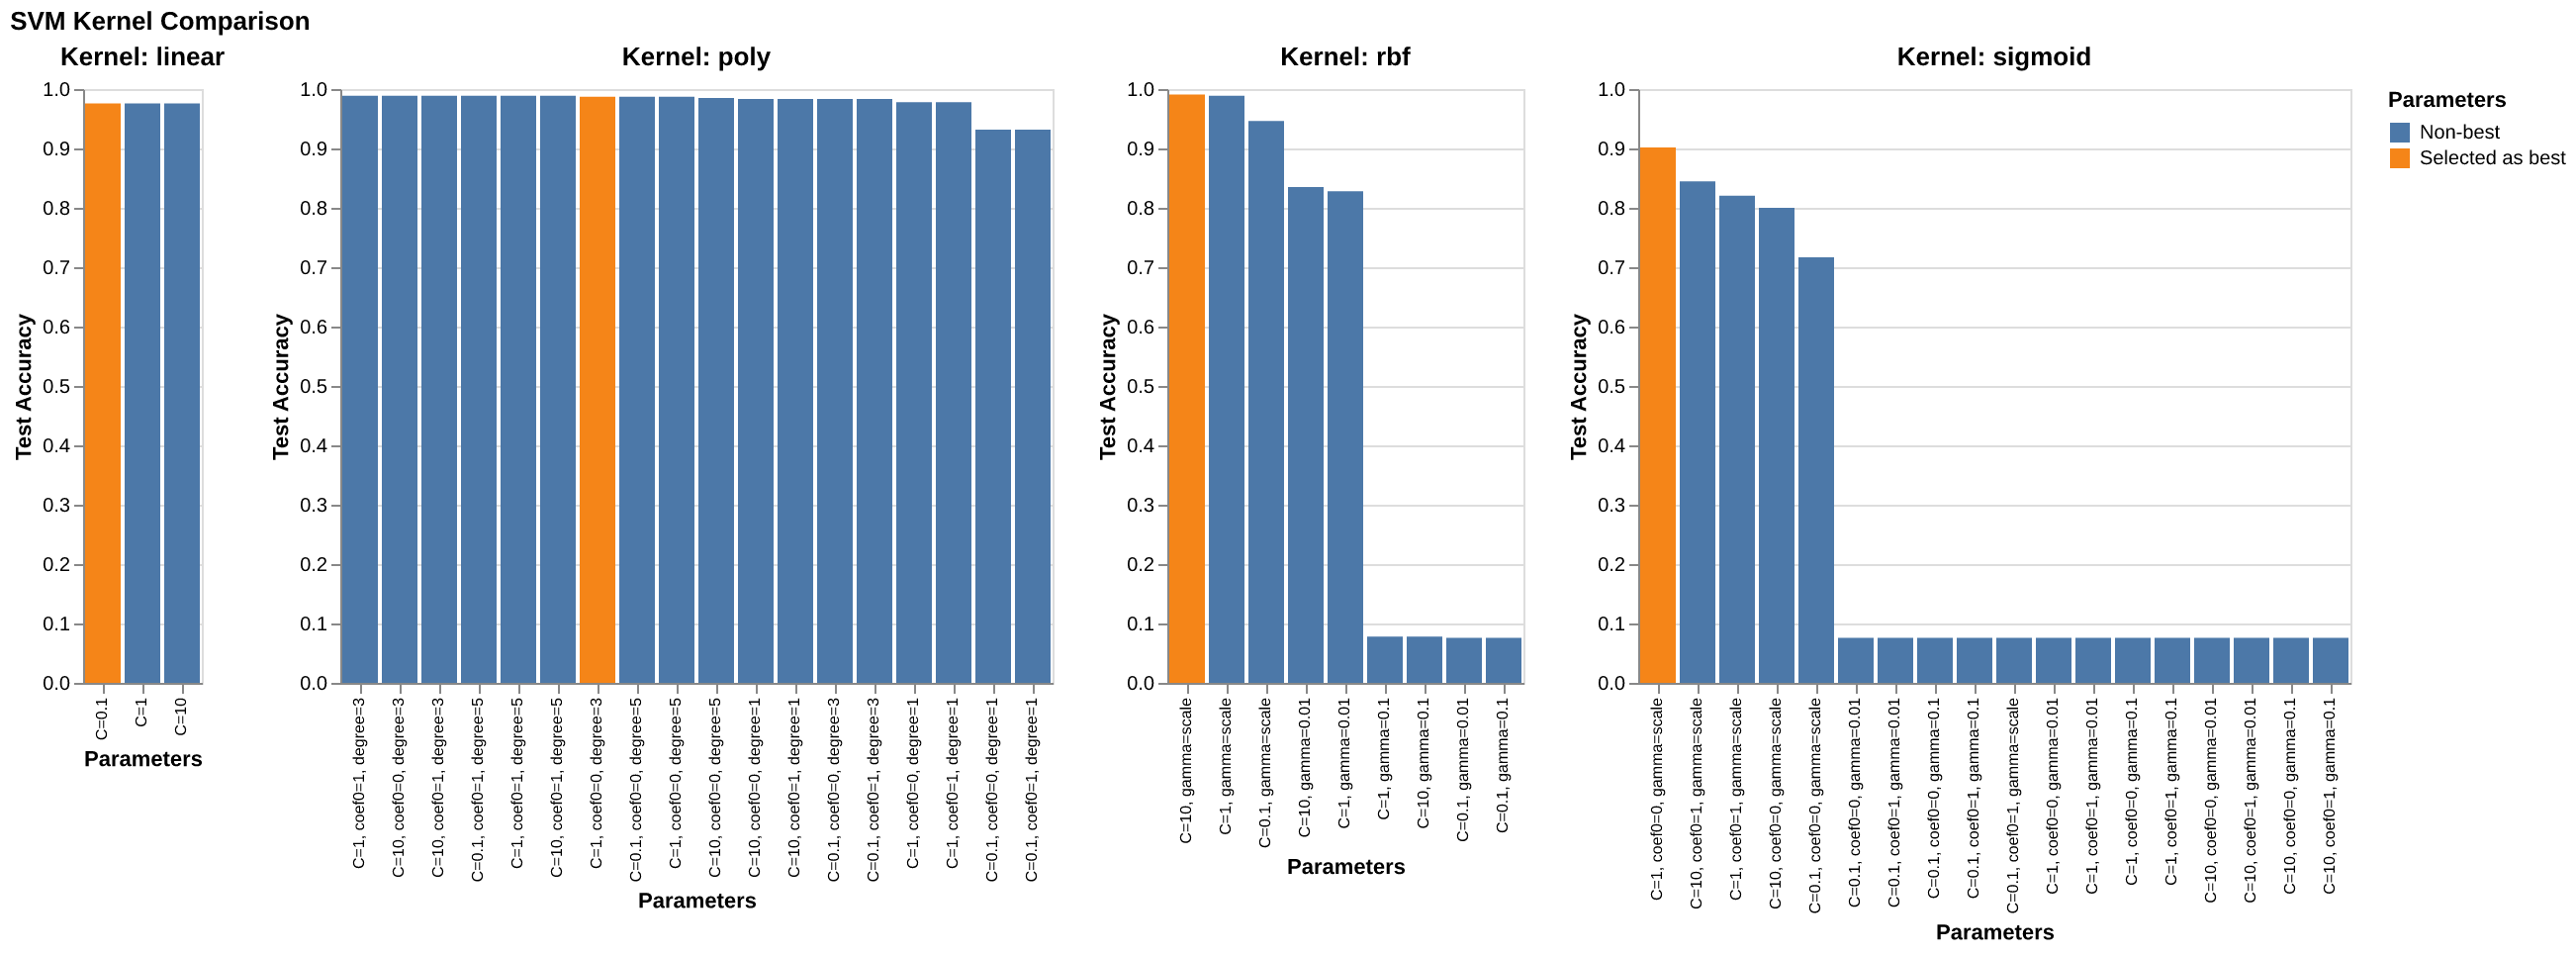

In [7]:
chart = create_kernel_comparison_chart(results, best_params)
display_chart(chart)

## Subtask 2: Develop Your Own Kernel

Develop a custom kernel that achieves higher accuracy as compared to your results from the previous subtask.

- Describe your kernel and the idea behind your kernel.
- Proof/argue that you actually implemented a valid kernel.
- If you fail to achieve higher accuracy, describe what you tried/thought about.

*Hint: familiarize yourself with the classification task; in particular, the meaning of the features.*

---

In [8]:
print("===== Dataset Information =====")
print(f"Shape: {digits.data.shape}")
print(f"Classes: {digits.target_names}")
print(f"Number of classes: {len(np.unique(digits.target))}")
print(f"Feature range: [{digits.data.min()};{digits.data.max()}]")

===== Dataset Information =====
Shape: (1797, 64)
Classes: [0 1 2 3 4 5 6 7 8 9]
Number of classes: 10
Feature range: [0.0;16.0]


### The Classification Task

The classification task is to predict the digit represented by an 8x8 image of a handwritten digit. The dataset contains 1797 images, each represented by 64 features (a digit is represented in a 8x8 grid), each of which is an integer between 0 and 16. The features represent the intensity of the pixel at the given position. The target is a digit between 0 and 9.

### The Idea Behind the Kernel

Knowing that in essence I have an image classification problem at hand, with tiny, 8x8 images, my first idea is to take advantage of this fact and use a kernel that is designed for image classification. I found a [paper](https://ieeexplore.ieee.org/document/1247294) with the title *Histogram intersection kernel for image classification* introducing the idea of using the color information of images to classify them.

#### Concept of Histogram Intersection Kernel

The HIK measures the similarity between two histograms by computing the intersection of their histograms. In mathematical terms, given two histograms, $H_1$ and $H_2$, each with $n$ bins, the HIK between $H_1$ and $H_2$ is defined as:

$$
\text{HIK}(H_1, H_2) = \sum_{i=1}^{n} \min(H_1[i], H_2[i])
$$

#### Interpretation

The interpretation of the HIK is intuitive:

- A high HIK value indicates a significant overlap between the histograms, signifying similarity between the underlying data distributions.
- A low HIK value implies little overlap, suggesting dissimilarity between the data distributions.

We can implement the described kernel in Python as follows:

In [9]:
def histogram_intersection_kernel(X, Y):
    # Compute the pairwise histogram intersection between rows of X and Y
    K = np.zeros((X.shape[0], Y.shape[0]))
    for i in range(X.shape[0]):
        for j in range(Y.shape[0]):
            intersection = np.minimum(X[i], Y[j])
            K[i, j] = np.sum(intersection)
    return K


accuracy = evaluate_svm_kernel(
    histogram_intersection_kernel,
    {},
    X_train,
    X_test,
    y_train,
    y_test,
)
print(f"Accuracy Score: {accuracy}")

Accuracy Score: 0.9907407407407407


### Accuracy Comparison

Interestingly, my custom kernel achieved the same score as the previous secion's best, the `rbf` with hyperparameters `C=10, gamma=scale`. Given that the accuracy is `0.9907`, this is an acceptable result.

### Proof of Kernel Validity

> The fact that there is a highly-cited paper describing this kernel is a decent indicator that it is in fact valid. But who can trust the peer-reviewed acceptance process of that work? We can never know, right? So let's prove this from first principles.

#### Definition of HIK

The HIK is defined as:
$$
HIK(H1, H2) = \sum_{i=1}^{n} \min(H1[i], H2[i])
$$
where $H1$ and $H2$ are histograms, and the sum is taken over all bins $i$ in the histograms.

#### Gram Matrix Construction

We can construct the Gram matrix $K$ using the HIK as follows:

$$
K_{ij} = HIK(H_i, H_j) = \sum_{k=1}^{n} \min(H_i[k], H_j[k])
$$

Here, $H_i$ and $H_j$ are histograms corresponding to data points $z_i$ and $z_j$.

#### Positive Semidefinite (PSD) Criterion

To prove that $K$ is PSD, we need to show that for any vector $z \in \mathbb{R}^n$, the following inequality holds:

$$
z^T K z \geq 0
$$

#### Proof

Consider $z \in \mathbb{R}^n$ as an arbitrary vector. We can express $z$ as $z = [z_1, z_2, \ldots, z_n]^T$, where $z_i$ are real numbers.

Now, we can write $z^T K z$ as follows:
$$
z^T K z = \sum_{i=1}^{n} \sum_{j=1}^{n} z_i z_j \min(H_i[j], H_j[j])
$$

Since $z_i$ and $z_j$ are real numbers and $\min(H_i[j], H_j[j])$ is non-negative, each term in the summation is non-negative. Therefore, $z^T K z$ is the sum of non-negative terms.

As a sum of non-negative terms, $z^T K z$ is always non-negative, which proves that $K$ is PSD.

The proof demonstrates that for any set of data points $z_1, z_2, \ldots, z_n$ and their corresponding histograms, the Gram matrix constructed using the Histogram Intersection Kernel (HIK) is positive semidefinite (PSD). Thus, the HIK satisfies Mercer's theorem and is indeed a valid kernel. Phew!


# Task 2: Feature Selection

In this task you will use the breast cancer dataset. Load the data and normalize it using the `MinMaxScaler`. Split the data into 70% training data and 30% test data (shuffle the data beforehand!). As the classification model use the `sklearn.svm.LinearSVC` with the default parameters.

In [10]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC

# Load the dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Normalize, shuffle and split the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y, test_size=0.3, random_state=42, shuffle=True
)

# Create and train a Linear Support Vector Classifier
classifier = LinearSVC(dual="auto")
classifier.fit(X_train, y_train)

# Evaluate the model
accuracy = classifier.score(X_test, y_test)
print(f"Accuracy Score: {accuracy}")

Accuracy Score: 0.9824561403508771


## Subtask 1: Forward Greedy Feature Selection

Implement forward greedy feature selection wrt the 10-fold cross-validation performance.

- Report the order of the features (including their names) for forward greedy feature selection.
- Record and report the performance of models for each of the number of features.

---

We start by defining the utility functions enabling us to perform the forward greedy feature selection. The core idea of the code below is to iteratively add the feature that improves the model's performance the most. The performance is measured using 10-fold cross-validation, using `KFold` from `sklearn.model_selection`. In `forward_greedy_feature_selection` we collect the results in a `DataFrame` and return it so that it is easy to analyze the results.

In [11]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC


def evaluate_features(X_subset: np.ndarray, y_train: np.ndarray) -> float:
    """Evaluate the performance of a feature subset using 10-fold cross-validation."""
    classifier = LinearSVC(dual="auto")
    cv_scores = cross_val_score(
        classifier,
        X_subset,
        y_train,
        cv=KFold(n_splits=10, shuffle=True, random_state=42),
    )
    mean_accuracy = np.mean(cv_scores)
    return mean_accuracy


def forward_greedy_feature_selection(
    X_train: np.ndarray, y_train: np.ndarray
) -> pd.DataFrame:
    """
    Perform forward greedy feature selection 
    and return a DataFrame with selected features and their performance.
    """
    selected_features = []
    best_accuracy = 0.0
    remaining_features = list(range(X_train.shape[1]))
    results = []

    while remaining_features:
        best_feature = None
        best_feature_accuracy = 0.0

        for feature in remaining_features:
            current_features = selected_features + [feature]
            accuracy = evaluate_features(X_train[:, current_features], y_train)

            if accuracy > best_feature_accuracy:
                best_feature_accuracy = accuracy
                best_feature = feature

        did_not_get_worse = best_feature_accuracy >= best_accuracy
        selected_features.append(best_feature)
        best_accuracy = best_feature_accuracy
        remaining_features.remove(best_feature)
        results.append(
            {
                "num_features": len(selected_features),
                "latest_feature": best_feature,
                "accuracy": best_feature_accuracy,
                "did_not_get_worse": did_not_get_worse,
            }
        )

    return pd.DataFrame(results)

Given all the utilities above we can perform the actual selection. The results are reported by the `DataFrame` below, clearly showing that we get increasing performance as we select more and more optimal features until the 13th feature. After that, the accuracy starts to drop, then interestingly, it starts to increas again and a max of `0.977436` is reached at 19 features. After that, the accuracy drops again.

A conventional implementation of this algorithm would stop at the first drop in accuracy, that is, it would return the first 13 features. However, for the sake of this report, I adjusted the algorithm to get better insights.

In [12]:
# Perform feature selection and attach the feature names
results_df = forward_greedy_feature_selection(X_train, y_train)
results_df["latest_feature"] = data.feature_names[results_df["latest_feature"]]
results_df

,num_features,latest_feature,accuracy,did_not_get_worse
0,1,worst perimeter,0.909808,True
1,2,worst smoothness,0.949936,True
2,3,worst texture,0.962500,True
3,4,worst radius,0.967500,True
4,5,worst concavity,0.970000,True
5,6,mean radius,0.972500,True
6,7,mean area,0.972500,True
7,8,mean compactness,0.972500,True
8,9,mean fractal dimension,0.972500,True
9,10,area error,0.972500,True


In [13]:
stop_index = results_df[results_df["did_not_get_worse"] == False].index[0] - 1
selected_features_forward = sorted(results_df.loc[:stop_index, "latest_feature"].tolist())

In [14]:
print("Features selected using forward greedy feature selection:")
selected_features_forward

Features selected using forward greedy feature selection:


['area error',
 'compactness error',
 'concavity error',
 'mean area',
 'mean compactness',
 'mean fractal dimension',
 'mean perimeter',
 'mean radius',
 'worst concavity',
 'worst perimeter',
 'worst radius',
 'worst smoothness',
 'worst texture']

## Subtask 2: Backward Greedy Feature Selection

- Report the order of the features (including their names) for backward greedy feature selection.
- Record and report the performance of models for each of the number of features.

---

In [15]:
def backward_greedy_feature_selection(
    X_train: np.ndarray, y_train: np.ndarray
) -> pd.DataFrame:
    """
    Perform backward greedy feature selection 
    and return a DataFrame with selected features and their performance.
    """
    selected_features = list(range(X_train.shape[1]))
    initial_accuracy = evaluate_features(X_train[:, selected_features], y_train)
    best_accuracy = initial_accuracy
    results = [
        {
            "num_features": len(selected_features),
            "removed_feature": None,
            "accuracy": best_accuracy,
        }
    ]

    while len(selected_features) > 1:
        worst_feature = None
        worst_feature_accuracy = best_accuracy

        for feature in selected_features:
            current_features = selected_features.copy()
            current_features.remove(feature)
            accuracy = evaluate_features(X_train[:, current_features], y_train)

            if accuracy >= worst_feature_accuracy:
                worst_feature_accuracy = accuracy
                worst_feature = feature

        # Check if a feature to remove was identified
        if worst_feature is not None:
            selected_features.remove(worst_feature)
            best_accuracy = worst_feature_accuracy
            results.append(
                {
                    "num_features": len(selected_features),
                    "removed_feature": worst_feature,
                    "accuracy": best_accuracy,
                }
            )
        else:
            # No feature found that can be removed without reducing accuracy, so stop
            break

    return pd.DataFrame(results)

Similarly to the previous subtask, the results are displayed in a `DataFrame` below. We start from an initial accuracy of `0.972436` when we use all 30 features (before removing any). This is in sync with our findings in the previous subtask where we got the same accuracy when using all features.  

The best performance is yielded after removing 20 features, giving us an accuracy of `0.977436`. After that, we stop being so greedy and stop the algorithm, as no feature can be removed without reducting the accuracy.

In [16]:
results_df = backward_greedy_feature_selection(X_train, y_train)
results_df["removed_feature"] = results_df["removed_feature"].apply(
    lambda feature: data.feature_names[int(feature)] if not np.isnan(feature) else None
)
results_df

,num_features,removed_feature,accuracy
0,30,None,0.972436
1,29,worst smoothness,0.974936
2,28,worst fractal dimension,0.974936
3,27,worst compactness,0.974936
4,26,worst area,0.974936
5,25,mean texture,0.977436
6,24,worst perimeter,0.977436
7,23,symmetry error,0.977436
8,22,concave points error,0.977436
9,21,concavity error,0.977436


In [17]:
features_removed = results_df["removed_feature"].dropna().tolist()
features_selected_backward = list(sorted(set(data.feature_names) - set(features_removed)))

In [18]:
print("Features selected using backward greedy feature selection:")
features_selected_backward

Features selected using backward greedy feature selection:


['compactness error',
 'mean concave points',
 'mean fractal dimension',
 'mean radius',
 'mean smoothness',
 'radius error',
 'worst concavity',
 'worst radius',
 'worst symmetry',
 'worst texture']

## Subtask 3: Feature Importance

Assume that you are only allowed to use 6 out of the 30 features for classification.

- Which features would you select using forward and backward feature selection?
- Do the features differ and if so, why?

---

In both cases I would take the algorithm's output considering the first 6 selected features. As the outputs below show, the features chosen this way will be different as in the forward selection we list the features we want to include, while in the backward selection we list the features we want to exclude. Therefore, when taking the top 6 features of the backward selection, we are essentially taking 6 from those features which were not removed.

In [19]:
top_6_forward = selected_features_forward[:6]
print("Top 6 features selected using forward greedy feature selection:")
top_6_forward

Top 6 features selected using forward greedy feature selection:


['area error',
 'compactness error',
 'concavity error',
 'mean area',
 'mean compactness',
 'mean fractal dimension']

In [20]:
top_6_backward = features_selected_backward[:6]
print("Top 6 features selected using backward greedy feature selection:")
top_6_backward

Top 6 features selected using backward greedy feature selection:


['compactness error',
 'mean concave points',
 'mean fractal dimension',
 'mean radius',
 'mean smoothness',
 'radius error']